# Harassment and Newcomer Retention over Time

In this notebook we investigate how receiving harassment correlates with newcomer activity and retention over Time. For the purposes of this study, our measures of harassment are classifiers over individual discussion comments for personal attacks, aggression and toxicity. These classifiers were developed [in previous work](https://arxiv.org/abs/1610.08914). We will investigate the relationship between harassment and newcomer retention through running regression models that use a measures of editing activity and harassment in time span t1 as independent variables and a measure of harassment in time span t2 as the dependent variable. This will be done for each year from 2011-2015 and we will examine the chronological trend.

In [28]:
% matplotlib inline
import pandas as pd
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as sm
import requests
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Data Preprocessing

In this section, we read the data and split it by year.

In [29]:
df_reg = pd.read_csv("../../data/retention/newcomer_sample_features.csv")

In [30]:
df_reg['timestamp'] = pd.to_datetime(df_reg['registration_day'], format='%Y-%m-%d')

In [31]:
df_reg['year'] = df_reg.timestamp.dt.year

In [32]:
YEARS = list(range(2006, 2016))

In [33]:
df_by_year = {}
for year in YEARS:
    df_by_year[year] = df_reg.query('year == %s' % year)

### Regression over Time

In this section, we analyze how harassment impacts a users activity level as it changes over time.

In [34]:
def regress(df, formula, family = 'linear'):
    if family == 'linear':
        result = sm.ols(formula=f, data=df).fit()
    elif family == 'logistic':
        result = sm.logit(formula=f, data=df).fit(disp=0)
    else:
        print("Wrong Family")
    return result

In [35]:
def get_coeffs_and_ci(df_dict, times, formula, family = 'linear', plot_coeff = 't1_harassment_received'):
    reg_coeffs = []
    lower_ci = []
    upper_ci = []
    for t in times:
        result = regress(df_dict[t], formula, family)
        reg_coeffs.append(result.params[plot_coeff])
        lower_ci.append(result.conf_int().loc[plot_coeff, 0])
        upper_ci.append(result.conf_int().loc[plot_coeff, 1])
    return reg_coeffs, lower_ci, upper_ci

In [36]:
def plot_coeffs_over_time(times, reg_coeffs, lower_ci, upper_ci):
    x = times
    y = reg_coeffs
    y_err = [np.subtract(y,lower_ci), np.subtract(upper_ci, y)]
    plt.errorbar(x,y,y_err)
    plt.xlim(times[0] - 1, times[-1] + 1)
    plt.ticklabel_format(useOffset=False)

In [37]:
def plot_formula(df_dict, times, formula, family = 'linear', plot_coeff = 't1_harassment_received'):
    reg_coeffs, lower_ci, upper_ci = get_coeffs_and_ci(df_dict, times, formula, family, plot_coeff)
    plot_coeffs_over_time(times, reg_coeffs, lower_ci, upper_ci)

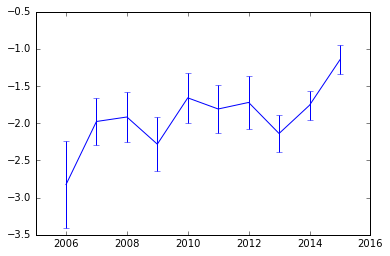

In [38]:
f = "t2_num_days_active ~ t1_num_days_active + t1_harassment_received"
plot_formula(df_by_year, YEARS, f)

In [39]:
df_gender = {}
for k in df_by_year:
    df_gender[k] = df_by_year[k].query('has_gender == 1')

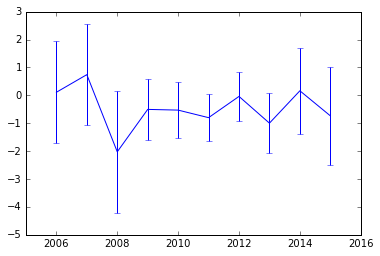

In [40]:
f="t2_num_days_active ~ t1_num_days_active + is_female"
plot_formula(df_gender, YEARS, f, plot_coeff='is_female')

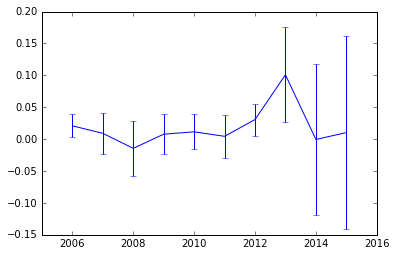

In [41]:
f="t1_harassment_received ~ is_female"
plot_formula(df_gender, YEARS, f, plot_coeff='is_female')

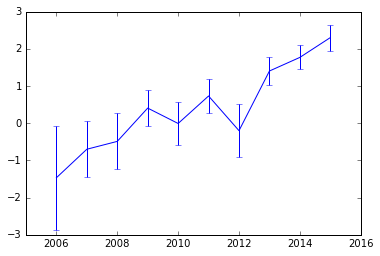

In [42]:
f="t1_harassment_received ~ has_gender"
plot_formula(df_by_year, YEARS, f, family = 'logistic', plot_coeff='has_gender')